In [49]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [50]:
x_begin = 0
x_end = 1.05

y_begin = 0
y_end = 1.05

h_x = 0.05
h_y = 0.05

In [51]:
# boundary conditions by x
def phi_0(y):
    return y

def phi_1(y):
    return 1 + y

# boundary conditions by y
def psi_0(x):
    return x

def psi_1(x):
    return 1 + x

# analytical solution
def solution(x, y):
    return x + y


In [52]:
def get_analytical_solution(
    x_range, # (x_begin, x_end)
    y_range, # (y_begin, y_end)
    h_x, # len of cell by x
    h_y, # len of cell by y
):
    """
    Get analytical solution of elliptical DE
    Returns matrix U with values of function
    """
    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)

    res = np.zeros((len(x), len(y)))
    for idx in range(len(x)):
        for idy in range(len(y)):
            res[idx][idy] = solution(x[idx], y[idy])

    return res

In [53]:
analytical_solution = get_analytical_solution(
    x_range=(x_begin, x_end),
    y_range=(y_begin, y_end),
    h_x=h_x,
    h_y=h_y,
)


In [54]:
solutions = dict()
solutions["analytical solution"] = analytical_solution

In [55]:
def max_abs_error(A, B):
    """
    Calculate max absolute error of elements of matrices A and B
    """
    assert A.shape == B.shape
    return abs(A - B).max()

In [56]:
def mean_abs_error(A, B):
    """
    Calculate mean absolute error of elements of matrices A and B
    """
    assert A.shape == B.shape
    return abs(A - B).mean()

In [57]:
def L2_norm(X):
    """
    Count ||X||_2
    """
    n = X.shape[0]
    l2_norm = 0
    for i in range(n):
        l2_norm += X[i] * X[i]
    return math.sqrt(l2_norm)

In [58]:
def plot_results(
    solutions, # dict: solutions[method name] = solution
    cur_y, # coord by y
    x_range, # (x_begin, x_end)
    y_range, # (y_begin, y_end)
    h_x, # len of cell by x
    h_y, # len of cell by y
):
    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)
    cur_y_id = abs(y - cur_y).argmin()

    plt.figure(figsize=(15, 9))
    for method_name, solution in solutions.items():
        plt.plot(x, solution[:, cur_y_id], label=method_name)

    plt.legend()
    plt.grid()
    plt.show()

In [59]:
def plot_errors_from_y(
    solutions, # dict: solutions[method name] = solution
    analytical_solution_name, # for comparing
    y_range, # (y_begin, y_end)
    h_y, # len of cell by y
):
    """
    Plot max_abs_error = f(y)
    """
    y = np.arange(*y_range, h_y)

    plt.figure(figsize=(15, 9))
    for method_name, solution in solutions.items():
        if method_name == analytical_solution_name:
            continue
        max_abs_errors = np.array([
            max_abs_error(solution[:, i], solutions[analytical_solution_name][:, i])
            for i in range(len(y))
        ])
        plt.plot(y, max_abs_errors, label=method_name)

    plt.xlabel('y')
    plt.ylabel('Max abs error')

    plt.legend()
    plt.grid()
    plt.show()


In [60]:
#Конечно-разностная схема
def finite_difference_schema(
    x_range, # (x_begin, x_end)
    y_range, # (y_begin, y_end)
    h_x, # len of cell by x
    h_y, # len of cell by y
    method, # method for solving system of equations
    phi_0=phi_0, # boundary condition 0 by x
    phi_1=phi_1, # boundary condition 1 by x
    psi_0=psi_0, # boundary condition 0 by y
    psi_1=psi_1, # boundary condition 1 by y
    eps=1e-7, # epsilon for solving system of equations
):
    """
    Solves elliptical DE using finite difference schema and one of numerical methods for system of equations.
    Returns matrix U with values of function
    """

    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)

    # Step 1. Initialise grid with border conditions
    res = np.zeros((len(x), len(y)))

    # rows 0, n -> use initial conditions by y
    for cur_x_id in range(len(x)):
        res[cur_x_id][0] = psi_0(x[cur_x_id])
        res[cur_x_id][-1] = psi_1(x[cur_x_id])

    # cols 0, n -> use initial conditions by x
    for cur_y_id in range(len(y)):
        res[0][cur_y_id] = phi_0(y[cur_y_id])
        res[-1][cur_y_id] = phi_1(y[cur_y_id])

    # Step 2. Create system of equations
    mapping = np.zeros((len(x), len(y)), dtype='int') # mapping[i][j] = id of equation with u_{i,j} = 1
    cur_eq_id = 0
    for cur_x_id in range(1, len(x)-1):
        for cur_y_id in range(1, len(y)-1):
            mapping[cur_x_id][cur_y_id] = cur_eq_id
            cur_eq_id += 1

    nums_of_equations = (len(x) - 2) * (len(y) - 2)
    A = np.zeros((nums_of_equations, nums_of_equations))
    b = np.zeros((nums_of_equations))
    for cur_x_id in range(1, len(x) - 1):
        for cur_y_id in range(1, len(y) - 1):
            cur_eq_id = mapping[cur_x_id][cur_y_id]

            A[cur_eq_id][mapping[cur_x_id][cur_y_id]] = 1 # u_{i, j}

            if cur_y_id-1 == 0:
                # u_{i, j-1} is already known from border conditions -> move the result to b
                b[cur_eq_id] += psi_0(x[cur_x_id]) * h_x**2 / (2 * (h_x**2 + h_y**2))
            else:
                A[cur_eq_id][mapping[cur_x_id][cur_y_id-1]] = -h_x**2 / (2 * (h_x**2 + h_y**2)) # u_{i, j-1}

            if cur_y_id+1 == len(y) - 1:
                # u_{i, j+1} is already known from border conditions -> move the result to b
                b[cur_eq_id] += psi_1(x[cur_x_id]) * h_x**2 / (2 * (h_x**2 + h_y**2))
            else:
                A[cur_eq_id][mapping[cur_x_id][cur_y_id+1]] = -h_x**2 / (2 * (h_x**2 + h_y**2)) # u_{i, j+1}

            if cur_x_id-1 == 0:
                # u_{i-1, j} is already known from border conditions -> move the result to b
                b[cur_eq_id] += phi_0(y[cur_y_id]) * h_y**2 / (2 * (h_x**2 + h_y**2))
            else:
                A[cur_eq_id][mapping[cur_x_id-1][cur_y_id]] = -h_y**2 / (2 * (h_x**2 + h_y**2)) # u_{i-1, j}

            if cur_x_id+1 == len(x) - 1:
                # u_{i+1, j} is already known from border conditions -> move the result to b
                b[cur_eq_id] += phi_1(y[cur_y_id]) * h_y**2 / (2 * (h_x**2 + h_y**2))
            else:
                A[cur_eq_id][mapping[cur_x_id+1][cur_y_id]] = -h_y**2 / (2 * (h_x**2 + h_y**2)) # u_{i+1, j}

    # Step 3. Solve system of equations
    ans, iters = method(A, b, eps)
    for cur_x_id in range(1, len(x) - 1):
        for cur_y_id in range(1, len(y) - 1):
            res[cur_x_id][cur_y_id] = ans[mapping[cur_x_id][cur_y_id]]

    return res, iters

In [61]:
#Метод простых итераций для решения СЛАУ
def iterative(A, b, eps):
    """
    Uses iterative method to solve Ax=b
    Returns x and number of iterations
    """
    n = A.shape[0]

    # Step 1. Ax=b -> x = alpha * x + beta
    alpha = np.zeros_like(A, dtype='float')
    beta = np.zeros_like(b, dtype='float')
    for i in range(n):
        for j in range(n):
            if i == j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -A[i][j] / A[i][i]

        beta[i] = b[i] / A[i][i]

    # Step 2. Iterating
    iterations = 0
    cur_x = np.copy(beta)
    converge = False
    while not converge:
        prev_x = np.copy(cur_x)
        cur_x = alpha @ prev_x + beta
        iterations += 1
        converge = L2_norm(prev_x - cur_x) <= eps
    return cur_x, iterations


In [62]:
iterative_solution, iterative_iters = finite_difference_schema(
    x_range=(x_begin, x_end),
    y_range=(y_begin, y_end),
    h_x=h_x,
    h_y=h_y,
    method=iterative,
    eps=1e-7,
)



In [63]:
solutions["iterative solution"] = iterative_solution

In [64]:
print(f'max abs error = {max_abs_error(iterative_solution, analytical_solution)}')
print(f'mean abs error = {mean_abs_error(iterative_solution, analytical_solution)}')

print(f'iterations = {iterative_iters}')

max abs error = 7.991032178189528e-07
mean abs error = 2.925360055610478e-07
iterations = 1171


In [65]:
#Метод Зейделя для решения СЛАУ
def seidel_multiplication(alpha, x, beta):
    """
    Count alhpa * x + beta for seidel method
    """
    res = np.copy(x)
    for i in range(alpha.shape[0]):
        res[i] = beta[i]
        for j in range(alpha.shape[1]):
            res[i] += alpha[i][j] * res[j]
    return res


def seidel(A, b, eps):
    """
    Uses Seidel method to solve Ax=b
    Returns x and number of iterations
    """
    n = A.shape[0]

    # Step 1. Ax=b -> x = alpha * x + beta
    alpha = np.zeros_like(A, dtype='float')
    beta = np.zeros_like(b, dtype='float')
    for i in range(n):
        for j in range(n):
            if i == j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -A[i][j] / A[i][i]

        beta[i] = b[i] / A[i][i]

    # Step 2. Iterating
    iterations = 0
    cur_x = np.copy(beta)
    converge = False
    while not converge:
        prev_x = np.copy(cur_x)
        cur_x = seidel_multiplication(alpha, prev_x, beta)
        iterations += 1
        converge = L2_norm(prev_x - cur_x) <= eps
    return cur_x, iterations



In [66]:
seidel_solution, seidel_iters = finite_difference_schema(
    x_range=(x_begin, x_end),
    y_range=(y_begin, y_end),
    h_x=h_x,
    h_y=h_y,
    method=seidel,
    eps=1e-7,
)

In [67]:
solutions["seidel solution"] = seidel_solution

In [68]:
print(f'max abs error = {max_abs_error(seidel_solution, analytical_solution)}')
print(f'mean abs error = {mean_abs_error(seidel_solution, analytical_solution)}')

print(f'iterations = {seidel_iters}')


max abs error = 3.9464804979516543e-07
mean abs error = 1.448952778319784e-07
iterations = 617


In [69]:
#Метод верхних релаксаций для решения СЛАУ
def relaxation(A, b, eps, w=1.5):
    """
    Uses relaxation method to solve Ax=b
    Returns x and number of iterations
    """
    n = A.shape[0]

    # Step 1. Ax=b -> x = alpha * x + beta
    alpha = np.zeros_like(A, dtype='float')
    beta = np.zeros_like(b, dtype='float')
    for i in range(n):
        for j in range(n):
            if i == j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -A[i][j] / A[i][i]

        beta[i] = b[i] / A[i][i]

    # Step 2. Iterating
    iterations = 0
    cur_x = np.copy(beta)
    converge = False
    while not converge:
        prev_x = np.copy(cur_x)
        cur_x = seidel_multiplication(alpha, prev_x, beta)
        cur_x = w * cur_x + (1-w) * prev_x
        iterations += 1
        converge = L2_norm(prev_x - cur_x) <= eps
    return cur_x, iterations


In [70]:
relaxation_solution, relaxation_iters = finite_difference_schema(
    x_range=(x_begin, x_end),
    y_range=(y_begin, y_end),
    h_x=h_x,
    h_y=h_y,
    method=relaxation,
    eps=1e-7,
)

In [71]:
solutions["relaxation solution"] = relaxation_solution

In [72]:
print(f'max abs error = {max_abs_error(relaxation_solution, analytical_solution)}')
print(f'mean abs error = {mean_abs_error(relaxation_solution, analytical_solution)}')

print(f'iterations = {relaxation_iters}')

max abs error = 2.591992710465618e-07
mean abs error = 9.516517408715057e-08
iterations = 420


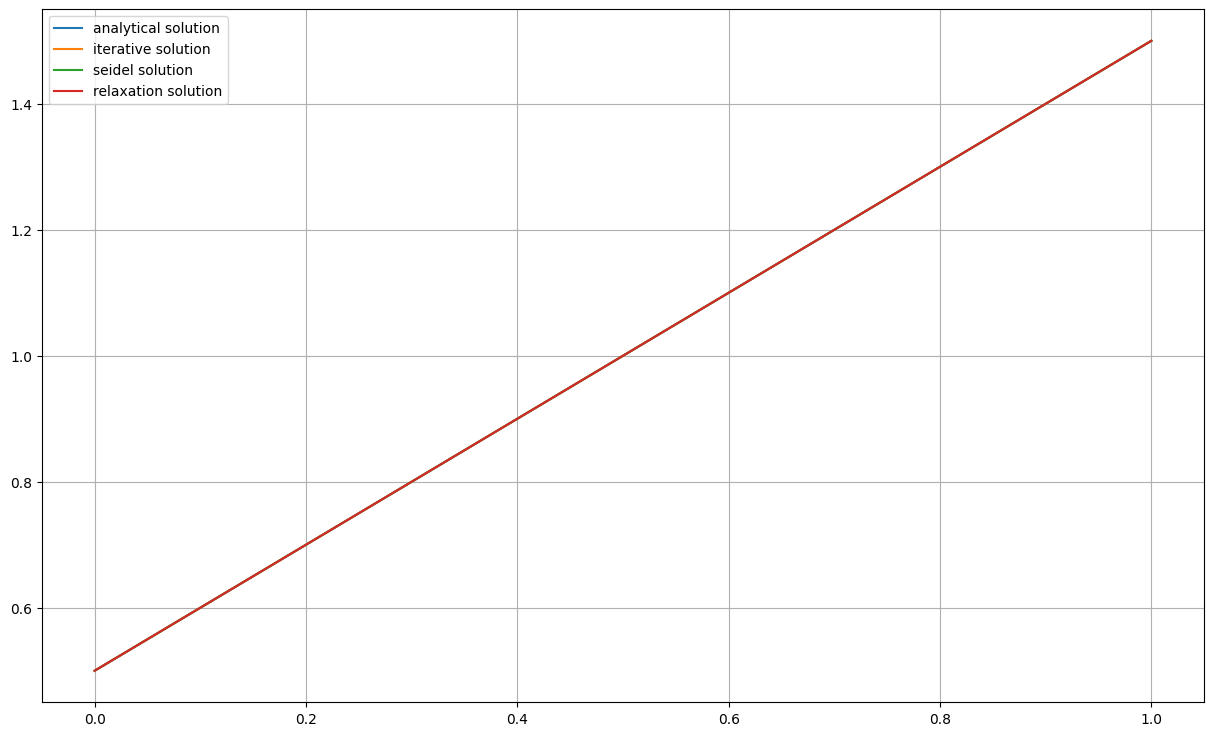

In [73]:
#Визуализация
plot_results(
    solutions=solutions,
    cur_y=0.5,
    x_range=(x_begin, x_end),
    y_range=(y_begin, y_end),
    h_x=h_x,
    h_y=h_y,
)

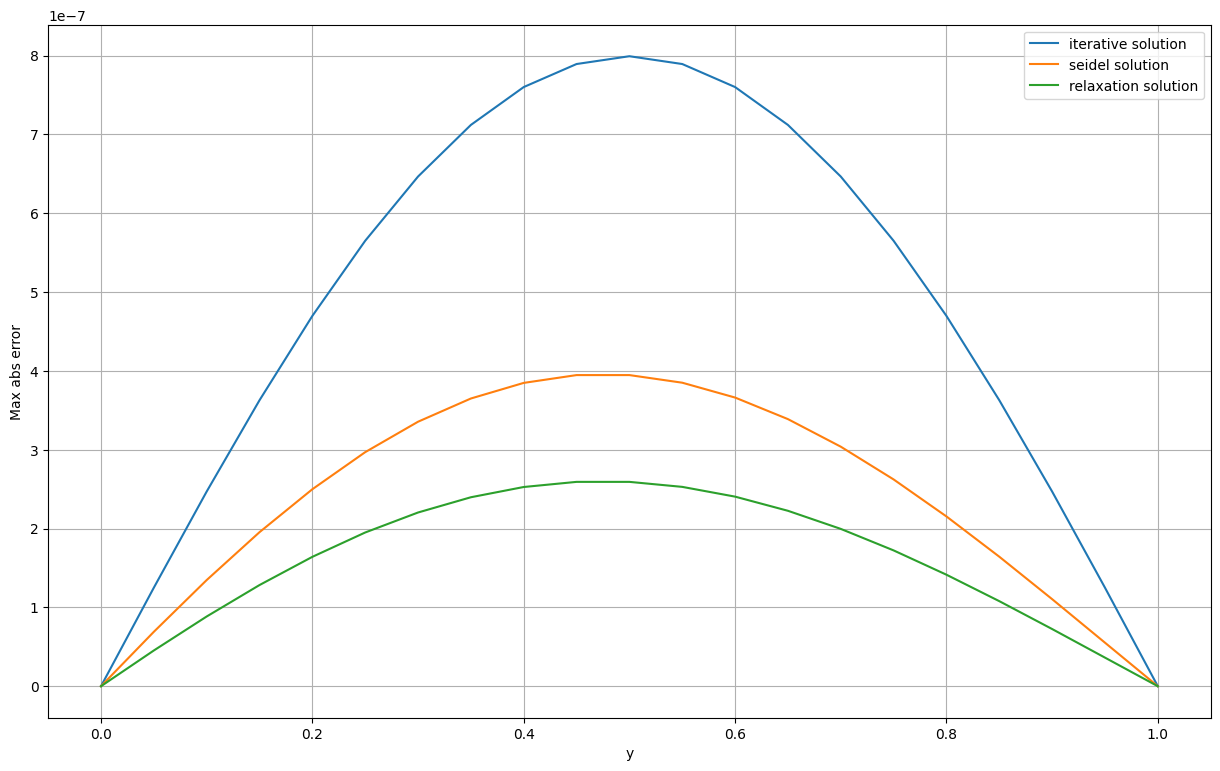

In [74]:
plot_errors_from_y(
    solutions=solutions,
    analytical_solution_name="analytical solution",
    y_range=(y_begin, y_end),
    h_y=h_y,
)